# PCA-Analyse der Schweizer Abstimmungsdaten

Diese Analyse untersucht die politischen Dimensionen im Abstimmungsverhalten der Schweizer Gemeinden.

**Basierend auf:** Hermann & Leuthold - Der politische Raum der Schweiz

**Die drei Dimensionen:**
1. **PC1: Liberal ↔ Konservativ** (gesellschaftlich: Einbürgerung, EU, Ausländerpolitik)
2. **PC2: Establishment ↔ Populistisch** (Regierungstreue vs. populistische Initiativen)
3. **PC3: Ökologisch ↔ Technokratisch** (Umwelt, Energie, Pestizide)

**Wichtiger Hinweis zu PC2:**
Die wirtschaftliche Links-Rechts-Dimension ist nicht eindeutig von PC2 abgebildet. 
PC2 trennt primär zwischen:
- **Establishment** (Goldküste: folgt Bundesratsempfehlungen bei AHV-Reformen)
- **Populistisch** (Innerschweiz: gegen Rentenaltererhöhung, für populistische Initiativen)

Dies erklärt, warum die konservative Innerschweiz (SVP) auf PC2 ähnlich wie linke Gemeinden erscheint.

---

## 1. Setup und Daten laden

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Plot-Einstellungen
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11
sns.set_style('whitegrid')

# Datenbankverbindung
DB_PATH = '../data/processed/swiss_votings.db'
conn = sqlite3.connect(DB_PATH)

print("Verbindung zur Datenbank hergestellt.")

Verbindung zur Datenbank hergestellt.


In [2]:
# Abstimmungsdaten laden
query = """
SELECT 
    municipality_id,
    municipality_name,
    proposal_id,
    voting_date,
    title_de,
    ja_prozent
FROM v_voting_results_analysis
WHERE ja_prozent IS NOT NULL
ORDER BY municipality_id, voting_date, proposal_id
"""

df_raw = pd.read_sql_query(query, conn)
print(f"Rohdaten geladen: {len(df_raw):,} Zeilen")
print(f"Gemeinden: {df_raw['municipality_id'].nunique()}")
print(f"Abstimmungsvorlagen: {df_raw['proposal_id'].nunique()}")
df_raw.head()

Rohdaten geladen: 471,595 Zeilen
Gemeinden: 2121
Abstimmungsvorlagen: 223


,municipality_id,municipality_name,proposal_id,voting_date,title_de,ja_prozent
0,1,Aeugst am Albis,1,20000312,Bundesbeschluss über die Justizreform,91.26
1,1,Aeugst am Albis,2,20000312,Volksinitiative «für Beschleunigung der direkt...,33.60
2,1,Aeugst am Albis,3,20000312,Volksinitiative «für eine gerechte Vertretung ...,21.14
3,1,Aeugst am Albis,4,20000312,Volksinitiative «zum Schutze des Menschen vor ...,30.60
4,1,Aeugst am Albis,5,20000312,Volksinitiative «für die Halbierung des motori...,26.68


## 2. Datenmatrix erstellen (Gemeinden × Vorlagen)

In [3]:
# Pivot: Zeilen = Gemeinden, Spalten = Abstimmungsvorlagen
# Werte = Ja-Prozent

df_pivot = df_raw.pivot_table(
    index=['municipality_id', 'municipality_name'],
    columns='proposal_id',
    values='ja_prozent',
    aggfunc='first'  # Sollte keine Duplikate geben
)

print(f"Matrix-Dimensionen: {df_pivot.shape[0]} Gemeinden × {df_pivot.shape[1]} Vorlagen")
print(f"\nFehlende Werte pro Vorlage (erste 10):")
print(df_pivot.isnull().sum().head(10))

Matrix-Dimensionen: 2121 Gemeinden × 223 Vorlagen

Fehlende Werte pro Vorlage (erste 10):
proposal_id
1     12
2     12
3     12
4     12
5     12
6     12
7     12
8     12
9     12
10    12
dtype: int64


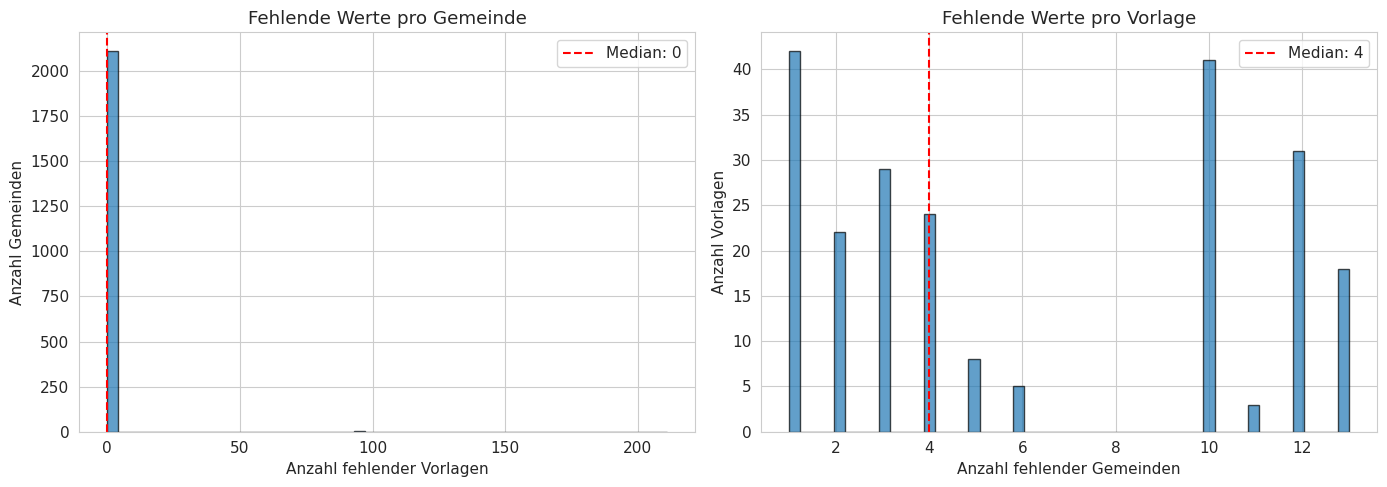


Gemeinden mit >50% fehlenden Werten: 4
Vorlagen mit >50% fehlenden Gemeinden: 0


In [4]:
# Fehlende Werte analysieren
missing_per_municipality = df_pivot.isnull().sum(axis=1)
missing_per_proposal = df_pivot.isnull().sum(axis=0)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Fehlende Werte pro Gemeinde
axes[0].hist(missing_per_municipality, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Anzahl fehlender Vorlagen')
axes[0].set_ylabel('Anzahl Gemeinden')
axes[0].set_title('Fehlende Werte pro Gemeinde')
axes[0].axvline(missing_per_municipality.median(), color='red', linestyle='--', 
                label=f'Median: {missing_per_municipality.median():.0f}')
axes[0].legend()

# Fehlende Werte pro Vorlage
axes[1].hist(missing_per_proposal, bins=50, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Anzahl fehlender Gemeinden')
axes[1].set_ylabel('Anzahl Vorlagen')
axes[1].set_title('Fehlende Werte pro Vorlage')
axes[1].axvline(missing_per_proposal.median(), color='red', linestyle='--',
                label=f'Median: {missing_per_proposal.median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('missing_values_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\nGemeinden mit >50% fehlenden Werten: {(missing_per_municipality > df_pivot.shape[1]/2).sum()}")
print(f"Vorlagen mit >50% fehlenden Gemeinden: {(missing_per_proposal > df_pivot.shape[0]/2).sum()}")

In [5]:
# Entscheidung: Gemeinden und Vorlagen mit zu vielen fehlenden Werten entfernen
# Dann restliche NaN mit Spalten-Mittelwert imputieren

# Threshold: Max 20% fehlende Werte
MAX_MISSING_RATIO = 0.20

# Vorlagen filtern
valid_proposals = missing_per_proposal[missing_per_proposal <= df_pivot.shape[0] * MAX_MISSING_RATIO].index
df_filtered = df_pivot[valid_proposals]
print(f"Nach Vorlagen-Filter: {df_filtered.shape[1]} Vorlagen behalten (von {df_pivot.shape[1]})")

# Gemeinden filtern
missing_per_municipality_filtered = df_filtered.isnull().sum(axis=1)
valid_municipalities = missing_per_municipality_filtered[missing_per_municipality_filtered <= df_filtered.shape[1] * MAX_MISSING_RATIO].index
df_filtered = df_filtered.loc[valid_municipalities]
print(f"Nach Gemeinden-Filter: {df_filtered.shape[0]} Gemeinden behalten (von {df_pivot.shape[0]})")

print(f"\nFinale Matrix: {df_filtered.shape[0]} × {df_filtered.shape[1]}")
print(f"Verbleibende NaN: {df_filtered.isnull().sum().sum()} ({100*df_filtered.isnull().sum().sum()/(df_filtered.shape[0]*df_filtered.shape[1]):.2f}%)")

Nach Vorlagen-Filter: 223 Vorlagen behalten (von 223)
Nach Gemeinden-Filter: 2109 Gemeinden behalten (von 2121)

Finale Matrix: 2109 × 223
Verbleibende NaN: 30 (0.01%)


In [6]:
# Imputation: Fehlende Werte mit Spalten-Mittelwert (= Durchschnitt der Vorlage) füllen
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(df_filtered)

# DataFrame für spätere Referenz
df_imputed = pd.DataFrame(
    X_imputed, 
    index=df_filtered.index, 
    columns=df_filtered.columns
)

print(f"Imputation abgeschlossen. Shape: {df_imputed.shape}")
print(f"Verbleibende NaN: {df_imputed.isnull().sum().sum()}")

Imputation abgeschlossen. Shape: (2109, 223)
Verbleibende NaN: 0


## 3. Standardisierung

In [7]:
# Z-Standardisierung (wichtig für PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_imputed)

print(f"Standardisierte Matrix: {X_scaled.shape}")
print(f"Mittelwert (sollte ~0 sein): {X_scaled.mean():.6f}")
print(f"Std (sollte ~1 sein): {X_scaled.std():.6f}")

Standardisierte Matrix: (2109, 223)
Mittelwert (sollte ~0 sein): -0.000000
Std (sollte ~1 sein): 1.000000


## 4. Bestimmung der optimalen Faktorenzahl

In [8]:
# Vollständige PCA für Scree-Plot
pca_full = PCA()
pca_full.fit(X_scaled)

# Eigenwerte und erklärte Varianz
eigenvalues = pca_full.explained_variance_
explained_variance_ratio = pca_full.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

print("Erste 10 Komponenten:")
print("-" * 60)
print(f"{'PC':>4} {'Eigenwert':>12} {'Varianz %':>12} {'Kumulativ %':>12}")
print("-" * 60)
for i in range(10):
    print(f"{i+1:>4} {eigenvalues[i]:>12.3f} {explained_variance_ratio[i]*100:>11.2f}% {cumulative_variance[i]*100:>11.2f}%")

Erste 10 Komponenten:
------------------------------------------------------------
  PC    Eigenwert    Varianz %  Kumulativ %
------------------------------------------------------------
   1       80.070       35.89%       35.89%
   2       31.546       14.14%       50.03%
   3       20.098        9.01%       59.04%
   4       10.057        4.51%       63.54%
   5        8.784        3.94%       67.48%
   6        6.112        2.74%       70.22%
   7        4.319        1.94%       72.16%
   8        3.171        1.42%       73.58%
   9        2.569        1.15%       74.73%
  10        2.121        0.95%       75.68%


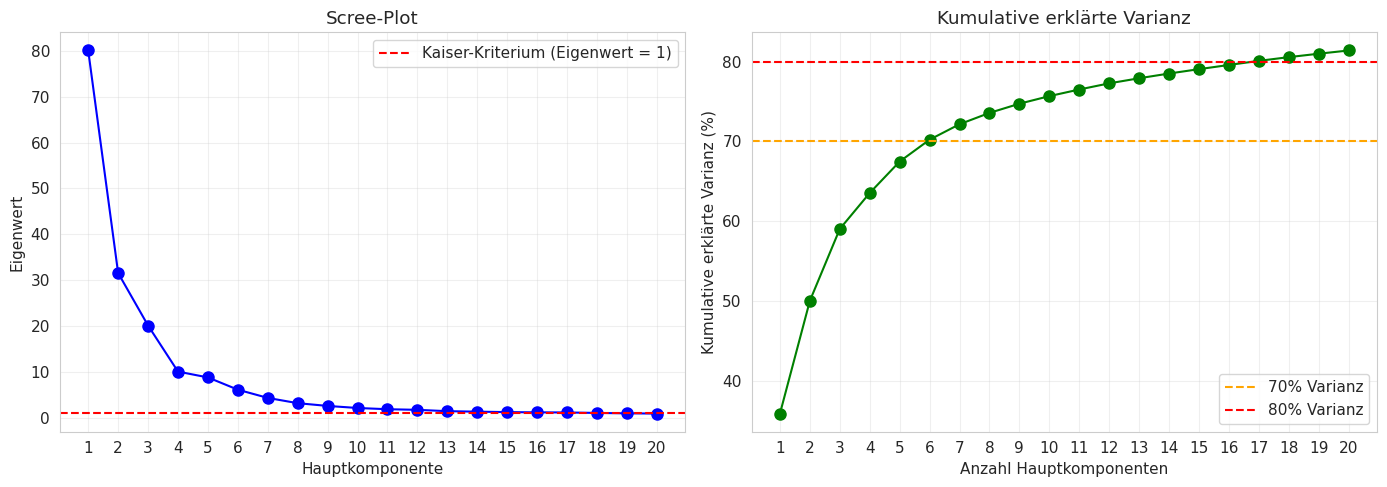


Kaiser-Kriterium: 18 Komponenten haben Eigenwert > 1
Diese erklären 80.6% der Varianz


In [9]:
# Scree-Plot und kumulative Varianz
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree-Plot (erste 20 Komponenten)
n_show = 20
axes[0].plot(range(1, n_show+1), eigenvalues[:n_show], 'bo-', markersize=8)
axes[0].axhline(y=1, color='r', linestyle='--', label='Kaiser-Kriterium (Eigenwert = 1)')
axes[0].set_xlabel('Hauptkomponente')
axes[0].set_ylabel('Eigenwert')
axes[0].set_title('Scree-Plot')
axes[0].set_xticks(range(1, n_show+1))
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Kumulative erklärte Varianz
axes[1].plot(range(1, n_show+1), cumulative_variance[:n_show]*100, 'go-', markersize=8)
axes[1].axhline(y=70, color='orange', linestyle='--', label='70% Varianz')
axes[1].axhline(y=80, color='red', linestyle='--', label='80% Varianz')
axes[1].set_xlabel('Anzahl Hauptkomponenten')
axes[1].set_ylabel('Kumulative erklärte Varianz (%)')
axes[1].set_title('Kumulative erklärte Varianz')
axes[1].set_xticks(range(1, n_show+1))
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scree_plot.png', dpi=150, bbox_inches='tight')
plt.show()

# Kaiser-Kriterium
n_kaiser = np.sum(eigenvalues > 1)
print(f"\nKaiser-Kriterium: {n_kaiser} Komponenten haben Eigenwert > 1")
print(f"Diese erklären {cumulative_variance[n_kaiser-1]*100:.1f}% der Varianz")

In [10]:
# Detailanalyse: Wieviele Faktoren sind sinnvoll?
print("Analyse der Faktorenzahl:")
print("=" * 60)

# Kaiser-Kriterium
print(f"\n1. Kaiser-Kriterium (Eigenwert > 1): {n_kaiser} Faktoren")

# Elbow-Methode (manuell identifizieren)
eigenvalue_diffs = np.diff(eigenvalues[:10])
print(f"\n2. Eigenwert-Differenzen (für Elbow):")
for i, diff in enumerate(eigenvalue_diffs):
    print(f"   PC{i+1} → PC{i+2}: {diff:.3f}")

# 70% und 80% Varianz
n_70 = np.argmax(cumulative_variance >= 0.70) + 1
n_80 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"\n3. Für 70% erklärte Varianz: {n_70} Faktoren")
print(f"   Für 80% erklärte Varianz: {n_80} Faktoren")

# Empfehlung basierend auf Literatur
print(f"\n4. Literatur (Hermann & Leuthold): 2-3 Faktoren")
print(f"   - 2 ausgeprägte Dimensionen")
print(f"   - 1 'halbe' Dimension (weniger stabil)")

Analyse der Faktorenzahl:

1. Kaiser-Kriterium (Eigenwert > 1): 18 Faktoren

2. Eigenwert-Differenzen (für Elbow):
   PC1 → PC2: -48.524
   PC2 → PC3: -11.448
   PC3 → PC4: -10.041
   PC4 → PC5: -1.272
   PC5 → PC6: -2.673
   PC6 → PC7: -1.793
   PC7 → PC8: -1.148
   PC8 → PC9: -0.602
   PC9 → PC10: -0.448

3. Für 70% erklärte Varianz: 6 Faktoren
   Für 80% erklärte Varianz: 17 Faktoren

4. Literatur (Hermann & Leuthold): 2-3 Faktoren
   - 2 ausgeprägte Dimensionen
   - 1 'halbe' Dimension (weniger stabil)


## 5. PCA mit 2 Faktoren

In [11]:
# PCA mit 2 Komponenten
pca_2 = PCA(n_components=2)
scores_2 = pca_2.fit_transform(X_scaled)

print(f"PCA mit 2 Faktoren:")
print(f"  Erklärte Varianz PC1: {pca_2.explained_variance_ratio_[0]*100:.2f}%")
print(f"  Erklärte Varianz PC2: {pca_2.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Total: {pca_2.explained_variance_ratio_.sum()*100:.2f}%")

# Scores DataFrame
df_scores_2 = pd.DataFrame(
    scores_2,
    columns=['PC1', 'PC2'],
    index=df_imputed.index
).reset_index()

df_scores_2.head()

PCA mit 2 Faktoren:
  Erklärte Varianz PC1: 35.89%
  Erklärte Varianz PC2: 14.14%
  Total: 50.03%


,municipality_id,municipality_name,PC1,PC2
0,1,Aeugst am Albis,3.143121,7.865694
1,10,Obfelden,0.711018,4.712791
2,100,Stadel,-10.424592,2.262766
3,1001,Doppleschwand,-16.356092,3.337881
4,1002,Entlebuch,-16.217931,-0.234665


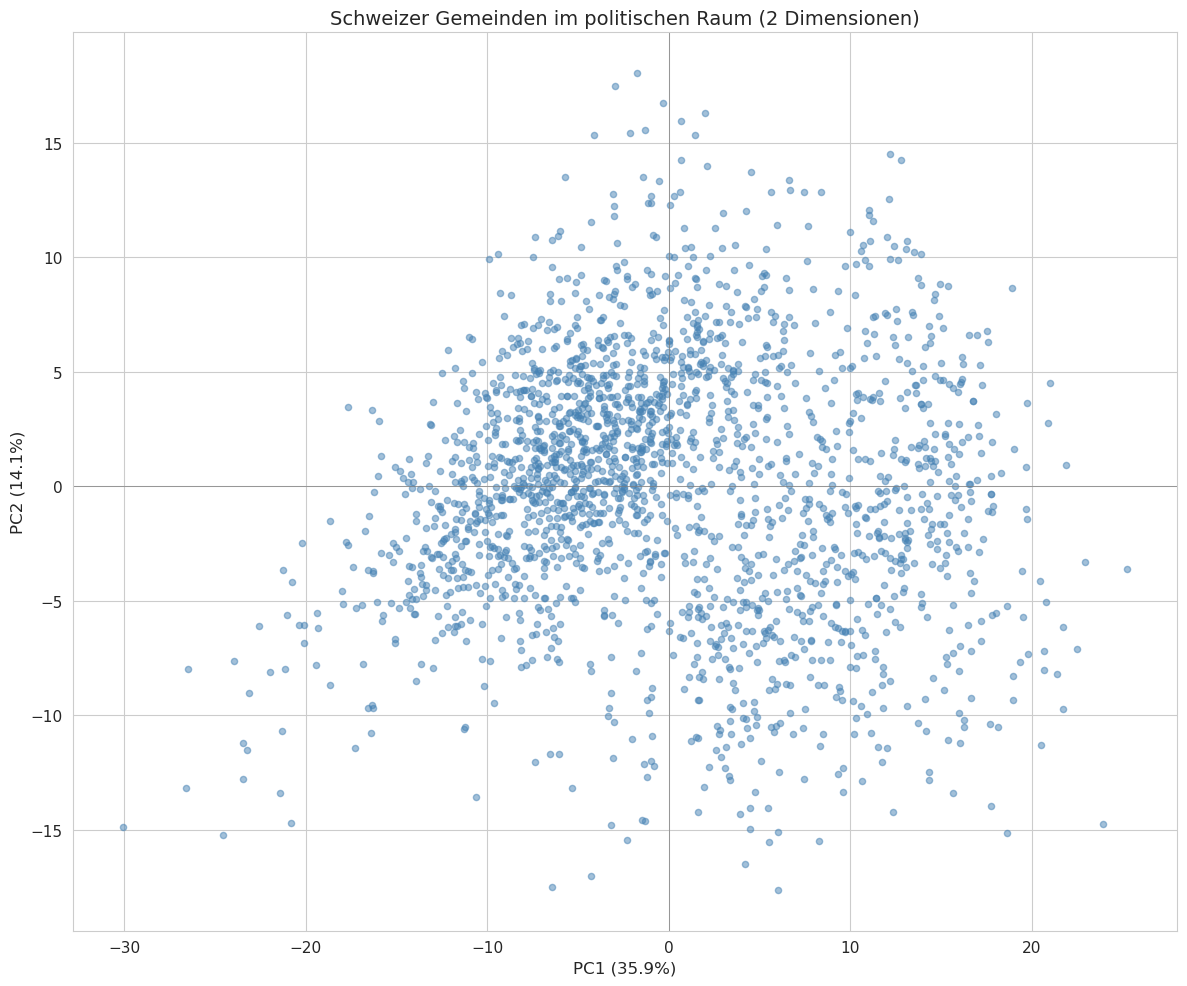

In [12]:
# Visualisierung: Gemeinden im 2D-Raum
fig, ax = plt.subplots(figsize=(12, 10))

scatter = ax.scatter(
    df_scores_2['PC1'], 
    df_scores_2['PC2'],
    alpha=0.5,
    s=20,
    c='steelblue'
)

ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca_2.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_2.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax.set_title('Schweizer Gemeinden im politischen Raum (2 Dimensionen)', fontsize=14)

plt.tight_layout()
plt.savefig('pca_2d_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

In [13]:
# Loadings für 2-Faktor-Lösung
loadings_2 = pd.DataFrame(
    pca_2.components_.T,
    columns=['PC1', 'PC2'],
    index=df_imputed.columns
)

# Vorlage-Titel hinzufügen
proposal_titles = pd.read_sql_query(
    "SELECT proposal_id, title_de, voting_date FROM proposals p JOIN votings v ON p.voting_id = v.voting_id",
    conn
)
proposal_titles = proposal_titles.set_index('proposal_id')

loadings_2['title'] = loadings_2.index.map(lambda x: proposal_titles.loc[x, 'title_de'] if x in proposal_titles.index else 'Unknown')
loadings_2['date'] = loadings_2.index.map(lambda x: proposal_titles.loc[x, 'voting_date'] if x in proposal_titles.index else 'Unknown')

print("Top 10 Vorlagen mit höchster positiver Ladung auf PC1 (Links-Rechts?):")
print(loadings_2.nlargest(10, 'PC1')[['PC1', 'title', 'date']])

print("\nTop 10 Vorlagen mit höchster negativer Ladung auf PC1:")
print(loadings_2.nsmallest(10, 'PC1')[['PC1', 'title', 'date']])

Top 10 Vorlagen mit höchster positiver Ladung auf PC1 (Links-Rechts?):
                  PC1                                              title  \
proposal_id                                                                
178          0.103796  Erwerbsersatzgesetz (indirekter Gegenvorschlag...   
59           0.103346  Bundesgesetz über die Erwerbsersatzordnung für...   
56           0.102346  Bundesbeschluss über die ordentliche Einbürger...   
57           0.101808  Bundesbeschluss über den Bürgerrechtserwerb vo...   
174          0.101782  Strafgesetzbuch und des Militärstrafgesetz (Di...   
111          0.100557           Bundesbeschluss über die Familienpolitik   
153          0.100419  Bundesbeschluss über die erleichterte Einbürge...   
18           0.099669                    Volksinitiative «Ja zu Europa!»   
199          0.098554  Änderung des Bundesgesetzes über Filmproduktio...   
196          0.096452  Volksinitiative «Ja zum Schutz der Kinder und ...   

                

In [14]:
print("Top 10 Vorlagen mit höchster positiver Ladung auf PC2 (Konservativ-Liberal?):")
print(loadings_2.nlargest(10, 'PC2')[['PC2', 'title', 'date']])

print("\nTop 10 Vorlagen mit höchster negativer Ladung auf PC2:")
print(loadings_2.nsmallest(10, 'PC2')[['PC2', 'title', 'date']])

Top 10 Vorlagen mit höchster positiver Ladung auf PC2 (Konservativ-Liberal?):
                  PC2                                              title  \
proposal_id                                                                
203          0.129934  Bundesbeschluss über die Zusatzfinanzierung de...   
53           0.126889  Bundesgesetz über die Alters- und Hinterlassen...   
17           0.124097                               Bundespersonalgesetz   
67           0.120230  Arbeitsgesetz (Ladenöffnungszeiten in Zentren ...   
204          0.115087  Änderung des Bundesgesetzes über die Alters- u...   
91           0.112630  Bundesbeschluss zur Schaffung einer Spezialfin...   
38           0.112036  Bundesgesetz über die obligatorische  Arbeitsl...   
205          0.111055  Änderung des Bundesgesetzes über die Verrechnu...   
22           0.110388  Bundesgesetz über die Armee und die Militärver...   
21           0.109508  Bundesgesetz über die Armee und die Militärver...   

         

## 6. PCA mit 3 Faktoren

In [15]:
# PCA mit 3 Komponenten
pca_3 = PCA(n_components=3)
scores_3 = pca_3.fit_transform(X_scaled)

print(f"PCA mit 3 Faktoren:")
print(f"  Erklärte Varianz PC1: {pca_3.explained_variance_ratio_[0]*100:.2f}%")
print(f"  Erklärte Varianz PC2: {pca_3.explained_variance_ratio_[1]*100:.2f}%")
print(f"  Erklärte Varianz PC3: {pca_3.explained_variance_ratio_[2]*100:.2f}%")
print(f"  Total: {pca_3.explained_variance_ratio_.sum()*100:.2f}%")

# Scores DataFrame
df_scores_3 = pd.DataFrame(
    scores_3,
    columns=['PC1', 'PC2', 'PC3'],
    index=df_imputed.index
).reset_index()

df_scores_3.head()

PCA mit 3 Faktoren:
  Erklärte Varianz PC1: 35.89%
  Erklärte Varianz PC2: 14.14%
  Erklärte Varianz PC3: 9.01%
  Total: 59.04%


,municipality_id,municipality_name,PC1,PC2,PC3
0,1,Aeugst am Albis,3.143121,7.865694,6.925142
1,10,Obfelden,0.711018,4.712791,4.482597
2,100,Stadel,-10.424592,2.262766,-1.008364
3,1001,Doppleschwand,-16.356092,3.337881,-10.168306
4,1002,Entlebuch,-16.217931,-0.234665,-6.754803


In [16]:
# Loadings für 3-Faktor-Lösung
loadings_3 = pd.DataFrame(
    pca_3.components_.T,
    columns=['PC1', 'PC2', 'PC3'],
    index=df_imputed.columns
)

loadings_3['title'] = loadings_3.index.map(lambda x: proposal_titles.loc[x, 'title_de'] if x in proposal_titles.index else 'Unknown')
loadings_3['date'] = loadings_3.index.map(lambda x: proposal_titles.loc[x, 'voting_date'] if x in proposal_titles.index else 'Unknown')

print("Top 10 Vorlagen mit höchster positiver Ladung auf PC3 (Technokratisch-Ökologisch?):")
print(loadings_3.nlargest(10, 'PC3')[['PC3', 'title', 'date']])

print("\nTop 10 Vorlagen mit höchster negativer Ladung auf PC3:")
print(loadings_3.nsmallest(10, 'PC3')[['PC3', 'title', 'date']])

Top 10 Vorlagen mit höchster positiver Ladung auf PC3 (Technokratisch-Ökologisch?):
                  PC3                                              title  \
proposal_id                                                                
185          0.168334  Volksinitiative «Für sauberes Trinkwasser und ...   
5            0.166086  Volksinitiative «für die Halbierung des motori...   
131          0.165776  Volksinitiative «Schluss mit den Steuerprivile...   
84           0.160148  Volksinitiative «für eine vernünftige Hanf-Pol...   
186          0.159593  Volksinitiative «Für eine Schweiz ohne synthet...   
202          0.157452  Volksinitiative «Keine Massentierhaltung in de...   
44           0.152490  Volksinitiative «für einen autofreien Sonntag ...   
138          0.148610  Volksinitiative «Millionen-Erbschaften besteue...   
113          0.142825                  Bundesgesetz über die Raumplanung   
25           0.136980  Volksinitiative «für eine gesicherte AHV - Ene...   

   

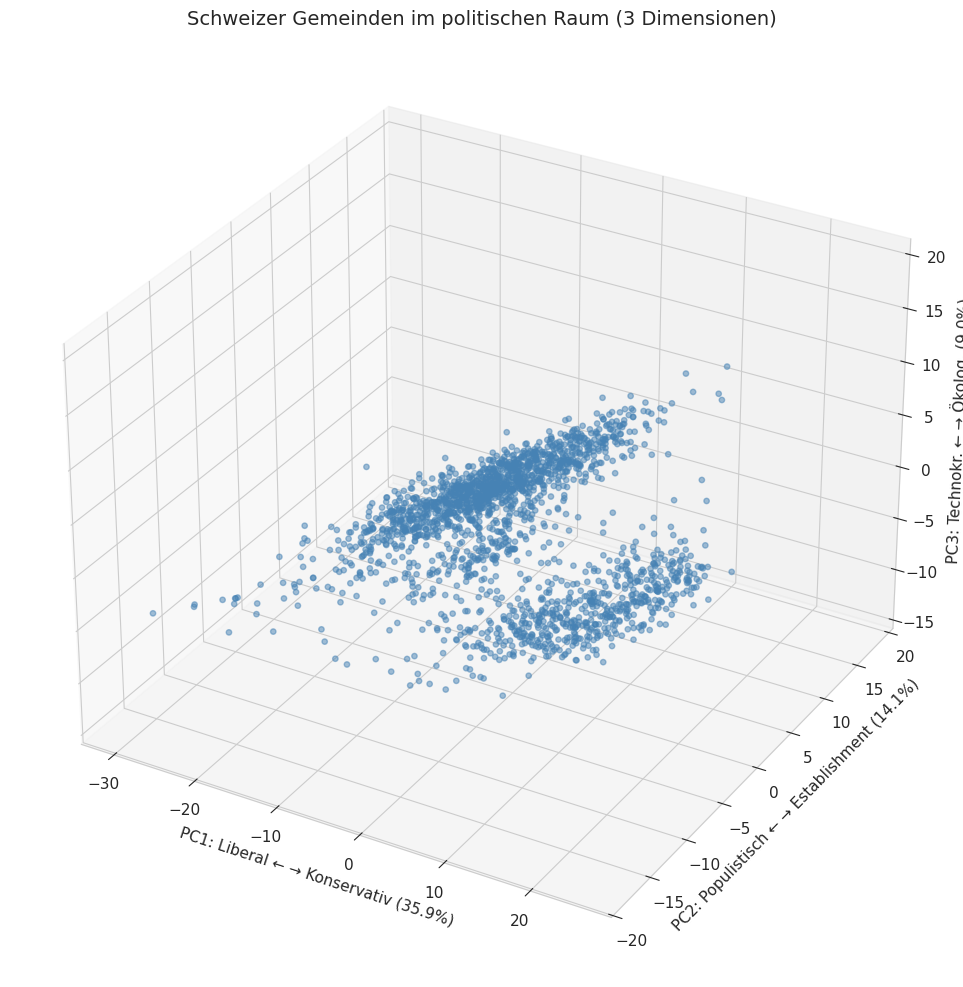

In [17]:
# 3D-Visualisierung
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(
    df_scores_3['PC1'],
    df_scores_3['PC2'],
    df_scores_3['PC3'],
    alpha=0.5,
    s=15,
    c='steelblue'
)

ax.set_xlabel(f'PC1: Liberal ← → Konservativ ({pca_3.explained_variance_ratio_[0]*100:.1f}%)')
ax.set_ylabel(f'PC2: Populistisch ← → Establishment ({pca_3.explained_variance_ratio_[1]*100:.1f}%)')
ax.set_zlabel(f'PC3: Technokr. ← → Ökolog. ({pca_3.explained_variance_ratio_[2]*100:.1f}%)')
ax.set_title('Schweizer Gemeinden im politischen Raum (3 Dimensionen)', fontsize=14)

plt.tight_layout()
plt.savefig('pca_3d_scatter.png', dpi=150, bbox_inches='tight')
plt.show()

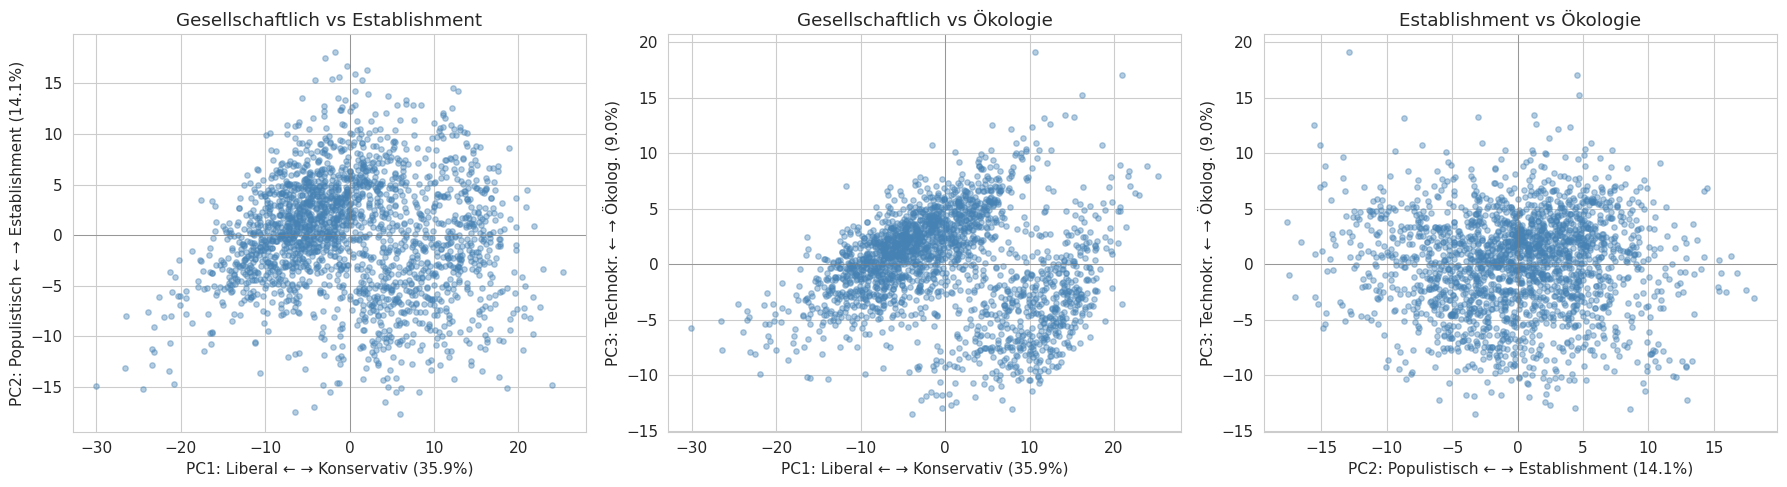

In [18]:
# Paarweise 2D-Plots für alle drei Dimensionen
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# PC1 vs PC2
axes[0].scatter(df_scores_3['PC1'], df_scores_3['PC2'], alpha=0.4, s=15, c='steelblue')
axes[0].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[0].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
axes[0].set_xlabel(f'PC1: Liberal ← → Konservativ ({pca_3.explained_variance_ratio_[0]*100:.1f}%)')
axes[0].set_ylabel(f'PC2: Populistisch ← → Establishment ({pca_3.explained_variance_ratio_[1]*100:.1f}%)')
axes[0].set_title('Gesellschaftlich vs Establishment')

# PC1 vs PC3
axes[1].scatter(df_scores_3['PC1'], df_scores_3['PC3'], alpha=0.4, s=15, c='steelblue')
axes[1].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[1].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
axes[1].set_xlabel(f'PC1: Liberal ← → Konservativ ({pca_3.explained_variance_ratio_[0]*100:.1f}%)')
axes[1].set_ylabel(f'PC3: Technokr. ← → Ökolog. ({pca_3.explained_variance_ratio_[2]*100:.1f}%)')
axes[1].set_title('Gesellschaftlich vs Ökologie')

# PC2 vs PC3
axes[2].scatter(df_scores_3['PC2'], df_scores_3['PC3'], alpha=0.4, s=15, c='steelblue')
axes[2].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[2].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
axes[2].set_xlabel(f'PC2: Populistisch ← → Establishment ({pca_3.explained_variance_ratio_[1]*100:.1f}%)')
axes[2].set_ylabel(f'PC3: Technokr. ← → Ökolog. ({pca_3.explained_variance_ratio_[2]*100:.1f}%)')
axes[2].set_title('Establishment vs Ökologie')

plt.tight_layout()
plt.savefig('pca_3_pairwise.png', dpi=150, bbox_inches='tight')
plt.show()

## 7. Interpretation der Achsen

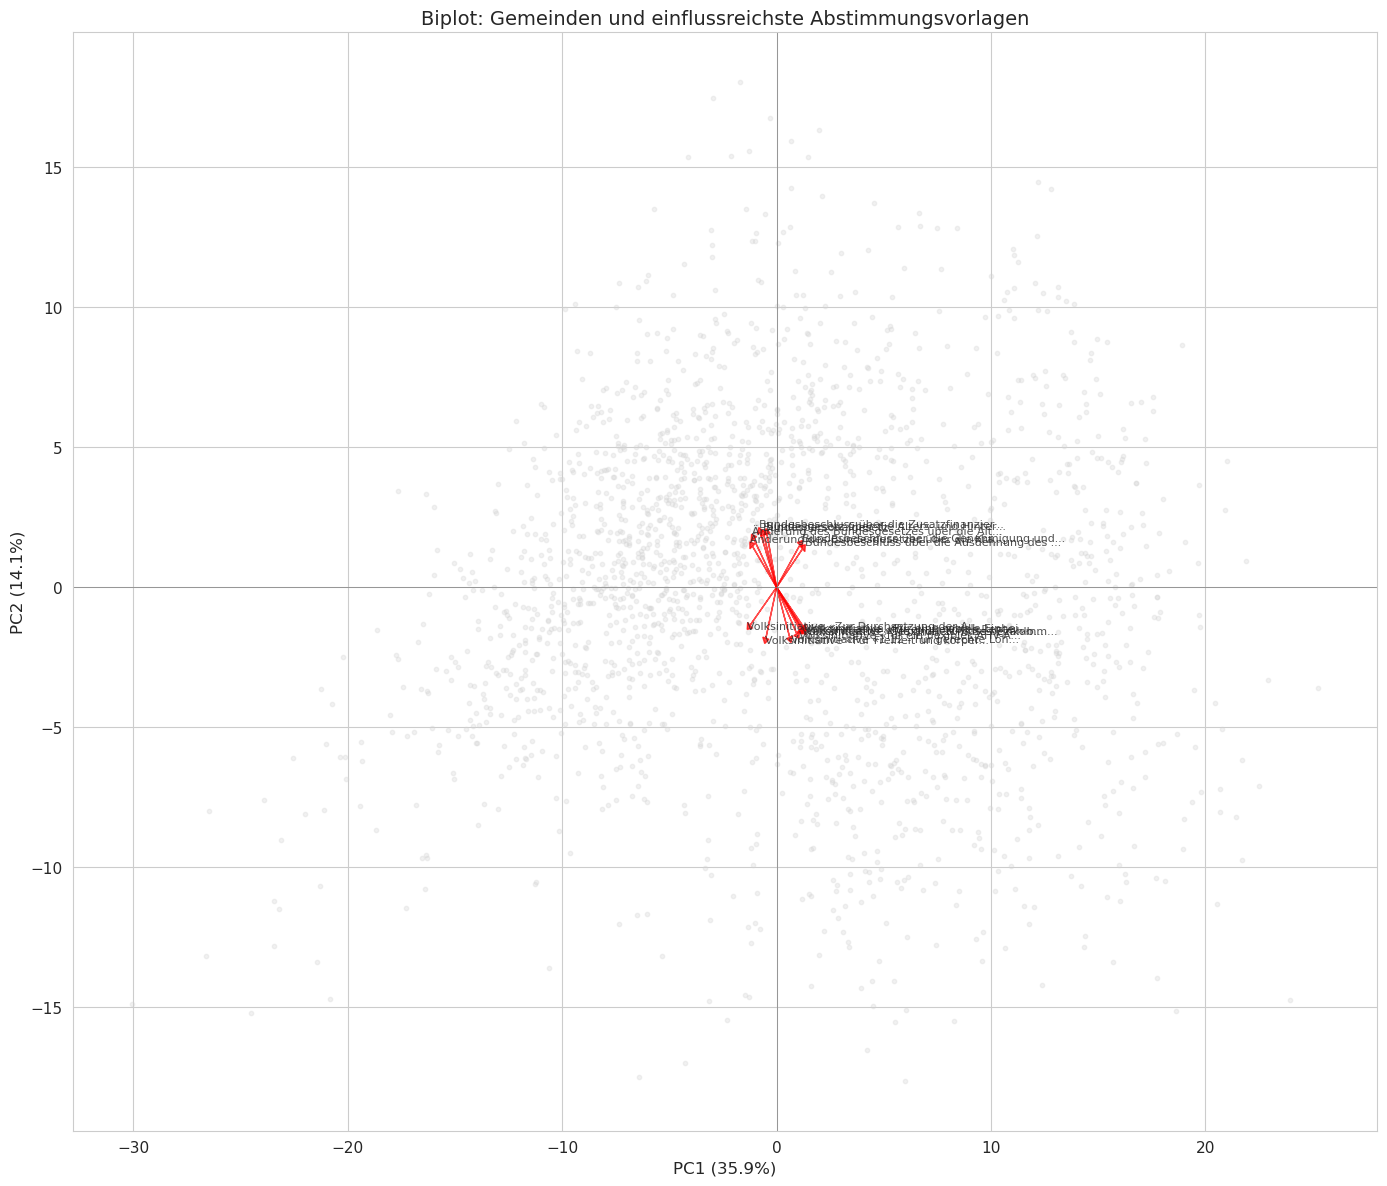

In [19]:
# Biplot für die ersten zwei Dimensionen (mit ausgewählten Vorlagen)
fig, ax = plt.subplots(figsize=(14, 12))

# Scores plotten (Gemeinden)
ax.scatter(df_scores_2['PC1'], df_scores_2['PC2'], alpha=0.3, s=10, c='lightgray', label='Gemeinden')

# Loadings als Vektoren (nur die extremsten)
n_arrows = 15

# Kombinierte Extremwerte finden
loadings_2['importance'] = np.sqrt(loadings_2['PC1']**2 + loadings_2['PC2']**2)
top_loadings = loadings_2.nlargest(n_arrows, 'importance')

# Skalierungsfaktor für bessere Sichtbarkeit
scale = 15

for idx, row in top_loadings.iterrows():
    ax.arrow(0, 0, row['PC1']*scale, row['PC2']*scale,
             head_width=0.3, head_length=0.2, fc='red', ec='red', alpha=0.7)
    # Kurztitel für Lesbarkeit
    short_title = row['title'][:40] + '...' if len(row['title']) > 40 else row['title']
    ax.annotate(short_title, 
                (row['PC1']*scale*1.1, row['PC2']*scale*1.1),
                fontsize=8, alpha=0.8)

ax.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
ax.set_xlabel(f'PC1 ({pca_2.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12)
ax.set_ylabel(f'PC2 ({pca_2.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12)
ax.set_title('Biplot: Gemeinden und einflussreichste Abstimmungsvorlagen', fontsize=14)

plt.tight_layout()
plt.savefig('biplot_2d.png', dpi=150, bbox_inches='tight')
plt.show()

In [20]:
# Achseninterpretation basierend auf Ladungen
print("="*80)
print("INTERPRETATION DER POLITISCHEN DIMENSIONEN")
print("="*80)

print("\n" + "-"*80)
print("PC1: LIBERAL ↔ KONSERVATIV (gesellschaftliche Dimension)")
print("-"*80)
print("\nLIBERALER Pol (hohe PC1) - Städte wie Zürich, Genf, Lausanne:")
for idx, row in loadings_3.nlargest(5, 'PC1').iterrows():
    print(f"  {row['PC1']:+.3f}  {row['date']} - {row['title'][:60]}")

print("\nKONSERVATIVER Pol (tiefe PC1) - Innerschweiz wie Muotathal:")
for idx, row in loadings_3.nsmallest(5, 'PC1').iterrows():
    print(f"  {row['PC1']:+.3f}  {row['date']} - {row['title'][:60]}")

print("\n" + "-"*80)
print("PC2: ESTABLISHMENT ↔ POPULISTISCH")
print("-"*80)
print("\nESTABLISHMENT Pol (hohe PC2) - Goldküste folgt Bundesrat:")
for idx, row in loadings_3.nlargest(5, 'PC2').iterrows():
    print(f"  {row['PC2']:+.3f}  {row['date']} - {row['title'][:60]}")

print("\nPOPULISTISCHER Pol (tiefe PC2) - gegen Regierungsvorlagen:")
for idx, row in loadings_3.nsmallest(5, 'PC2').iterrows():
    print(f"  {row['PC2']:+.3f}  {row['date']} - {row['title'][:60]}")

print("\n" + "-"*80)
print("PC3: ÖKOLOGISCH ↔ TECHNOKRATISCH")
print("-"*80)
print("\nÖKOLOGISCHER Pol (hohe PC3) - Städte:")
for idx, row in loadings_3.nlargest(5, 'PC3').iterrows():
    print(f"  {row['PC3']:+.3f}  {row['date']} - {row['title'][:60]}")

print("\nTECHNOKRATISCHER Pol (tiefe PC3):")
for idx, row in loadings_3.nsmallest(5, 'PC3').iterrows():
    print(f"  {row['PC3']:+.3f}  {row['date']} - {row['title'][:60]}")

INTERPRETATION DER POLITISCHEN DIMENSIONEN

--------------------------------------------------------------------------------
PC1: LIBERAL ↔ KONSERVATIV (gesellschaftliche Dimension)
--------------------------------------------------------------------------------

LIBERALER Pol (hohe PC1) - Städte wie Zürich, Genf, Lausanne:
  +0.104  20200927 - Erwerbsersatzgesetz (indirekter Gegenvorschlag zur Volksinit
  +0.103  20040926 - Bundesgesetz über die Erwerbsersatzordnung für Dienstleisten
  +0.102  20040926 - Bundesbeschluss über die ordentliche Einbürgerung sowie über
  +0.102  20040926 - Bundesbeschluss über den Bürgerrechtserwerb von Ausländerinn
  +0.102  20200209 - Strafgesetzbuch und des Militärstrafgesetz (Diskriminierung 

KONSERVATIVER Pol (tiefe PC1) - Innerschweiz wie Muotathal:
  -0.099  20080601 - Volksinitiative «Für demokratische Einbürgerungen»
  -0.097  20140209 - Volksinitiative «Abtreibungsfinanzierung ist Privatsache - E
  -0.097  20140518 - Bundesgesetz über den Fonds 

In [21]:
# Extreme Gemeinden identifizieren
print("="*80)
print("EXTREME GEMEINDEN IN DEN POLITISCHEN DIMENSIONEN")
print("="*80)

print("\n" + "-"*60)
print("PC1: Am LIBERALSTEN (gesellschaftlich offen):")
print("-"*60)
for idx, row in df_scores_3.nlargest(5, 'PC1').iterrows():
    print(f"  {row['PC1']:+.2f}  {row['municipality_name']}")

print("\nPC1: Am KONSERVATIVSTEN (gesellschaftlich traditionell):")
for idx, row in df_scores_3.nsmallest(5, 'PC1').iterrows():
    print(f"  {row['PC1']:+.2f}  {row['municipality_name']}")

print("\n" + "-"*60)
print("PC2: Am meisten ESTABLISHMENT (folgt Bundesrat):")
print("-"*60)
for idx, row in df_scores_3.nlargest(5, 'PC2').iterrows():
    print(f"  {row['PC2']:+.2f}  {row['municipality_name']}")

print("\nPC2: Am meisten POPULISTISCH (gegen Regierungsvorlagen):")
for idx, row in df_scores_3.nsmallest(5, 'PC2').iterrows():
    print(f"  {row['PC2']:+.2f}  {row['municipality_name']}")

print("\n" + "-"*60)
print("PC3: Am ÖKOLOGISCHSTEN:")
print("-"*60)
for idx, row in df_scores_3.nlargest(5, 'PC3').iterrows():
    print(f"  {row['PC3']:+.2f}  {row['municipality_name']}")

print("\nPC3: Am TECHNOKRATISCHSTEN:")
for idx, row in df_scores_3.nsmallest(5, 'PC3').iterrows():
    print(f"  {row['PC3']:+.2f}  {row['municipality_name']}")

# Bekannte Referenzgemeinden
print("\n" + "="*80)
print("REFERENZGEMEINDEN ZUR ORIENTIERUNG")
print("="*80)
ref_cities = ['Zürich', 'Zumikon', 'Muotathal', 'Genève', 'Bern', 'Schwyz']
for city in ref_cities:
    match = df_scores_3[df_scores_3['municipality_name'].str.contains(city, case=False, na=False)]
    if len(match) > 0:
        r = match.iloc[0]
        lib = "liberal" if r['PC1'] > 0 else "konservativ"
        est = "establishment" if r['PC2'] > 0 else "populistisch"
        oeko = "ökolog." if r['PC3'] > 0 else "technokr."
        print(f"  {r['municipality_name']:<20} PC1={r['PC1']:+6.1f} PC2={r['PC2']:+6.1f} PC3={r['PC3']:+6.1f}  → {lib}, {est}, {oeko}")

EXTREME GEMEINDEN IN DEN POLITISCHEN DIMENSIONEN

------------------------------------------------------------
PC1: Am LIBERALSTEN (gesellschaftlich offen):
------------------------------------------------------------
  +25.24  Lausanne
  +23.92  Lajoux (JU)
  +22.93  Vevey
  +22.51  Delémont
  +21.88  GE-CH de l'étranger

PC1: Am KONSERVATIVSTEN (gesellschaftlich traditionell):
  -30.07  Unteriberg
  -26.60  Alpthal
  -26.49  Muotathal
  -24.53  Vorderthal
  -23.93  Rothenthurm

------------------------------------------------------------
PC2: Am meisten ESTABLISHMENT (folgt Bundesrat):
------------------------------------------------------------
  +18.04  Zumikon
  +17.49  Uitikon
  +16.75  Erlenbach (ZH)
  +16.32  Zollikon
  +15.93  Kammersrohr

PC2: Am meisten POPULISTISCH (gegen Regierungsvorlagen):
  -17.63  Grandval
  -17.49  Saules (BE)
  -17.00  Roches (BE)
  -16.52  Perrefitte
  -15.54  Campo (Vallemaggia)

------------------------------------------------------------
PC3: Am 

## 8. Faktorrotation (Varimax) für bessere Interpretierbarkeit

In [22]:
from scipy.stats import special_ortho_group
from scipy.linalg import svd

def varimax_rotation(loadings, max_iter=100, tol=1e-6):
    """
    Varimax-Rotation für bessere Interpretierbarkeit der Faktoren.
    """
    n_vars, n_factors = loadings.shape
    rotation_matrix = np.eye(n_factors)
    
    for _ in range(max_iter):
        old_rotation = rotation_matrix.copy()
        
        # Rotierte Ladungen
        rotated = loadings @ rotation_matrix
        
        # Varimax-Kriterium maximieren
        tmp = rotated ** 3 - rotated * (rotated ** 2).sum(axis=0) / n_vars
        u, s, vh = svd(loadings.T @ tmp)
        rotation_matrix = u @ vh
        
        # Konvergenzprüfung
        if np.max(np.abs(rotation_matrix - old_rotation)) < tol:
            break
    
    return loadings @ rotation_matrix, rotation_matrix

# Varimax auf 3-Faktor-Lösung anwenden
loadings_raw = pca_3.components_.T
loadings_rotated, rotation_matrix = varimax_rotation(loadings_raw)

print("Varimax-Rotation durchgeführt.")
print(f"\nRotationsmatrix:\n{rotation_matrix}")

Varimax-Rotation durchgeführt.

Rotationsmatrix:
[[ 0.76758005 -0.64041477  0.02626366]
 [ 0.62321912  0.75528786  0.20282548]
 [-0.14972905 -0.13931678  0.97886263]]


In [23]:
# Rotierte Ladungen analysieren
loadings_rot_df = pd.DataFrame(
    loadings_rotated,
    columns=['RC1', 'RC2', 'RC3'],
    index=df_imputed.columns
)

loadings_rot_df['title'] = loadings_rot_df.index.map(lambda x: proposal_titles.loc[x, 'title_de'] if x in proposal_titles.index else 'Unknown')
loadings_rot_df['date'] = loadings_rot_df.index.map(lambda x: proposal_titles.loc[x, 'voting_date'] if x in proposal_titles.index else 'Unknown')

print("="*80)
print("ROTIERTE FAKTOREN (VARIMAX)")
print("="*80)

for rc in ['RC1', 'RC2', 'RC3']:
    print(f"\n{'-'*60}")
    print(f"{rc}: Top 5 positive Ladungen")
    print(f"{'-'*60}")
    for idx, row in loadings_rot_df.nlargest(5, rc).iterrows():
        print(f"  {row[rc]:.3f}  {row['date']} - {row['title'][:55]}")
    
    print(f"\n{rc}: Top 5 negative Ladungen")
    for idx, row in loadings_rot_df.nsmallest(5, rc).iterrows():
        print(f"  {row[rc]:.3f}  {row['date']} - {row['title'][:55]}")

ROTIERTE FAKTOREN (VARIMAX)

------------------------------------------------------------
RC1: Top 5 positive Ladungen
------------------------------------------------------------
  0.119  20050925 - Bundesbeschluss über die Ausdehnung des Personenfreizüg
  0.115  20061126 - Bundesgesetz über die Zusammenarbeit mit den Staaten Os
  0.115  20090208 - Weiterführung des Freizügigkeitsabkommens zwischen der 
  0.115  20050605 - Bundesbeschluss über die Genehmigung und die Umsetzung 
  0.114  20250928 - Bundesgesetz über den elektronischen Identitätsnachweis

RC1: Top 5 negative Ladungen
  -0.117  20160228 - Volksinitiative «Zur Durchsetzung der Ausschaffung krim
  -0.117  20200927 - Volksinitiative «Für eine massvolle Zuwanderung (Begren
  -0.115  20140209 - Volksinitiative «Gegen Masseneinwanderung»
  -0.112  20141130 - Volksinitiative «Rettet unser Schweizer Gold (Gold-Init
  -0.112  20141130 - Volksinitiative «Stopp der Überbevölkerung - zur Sicher

-------------------------------------

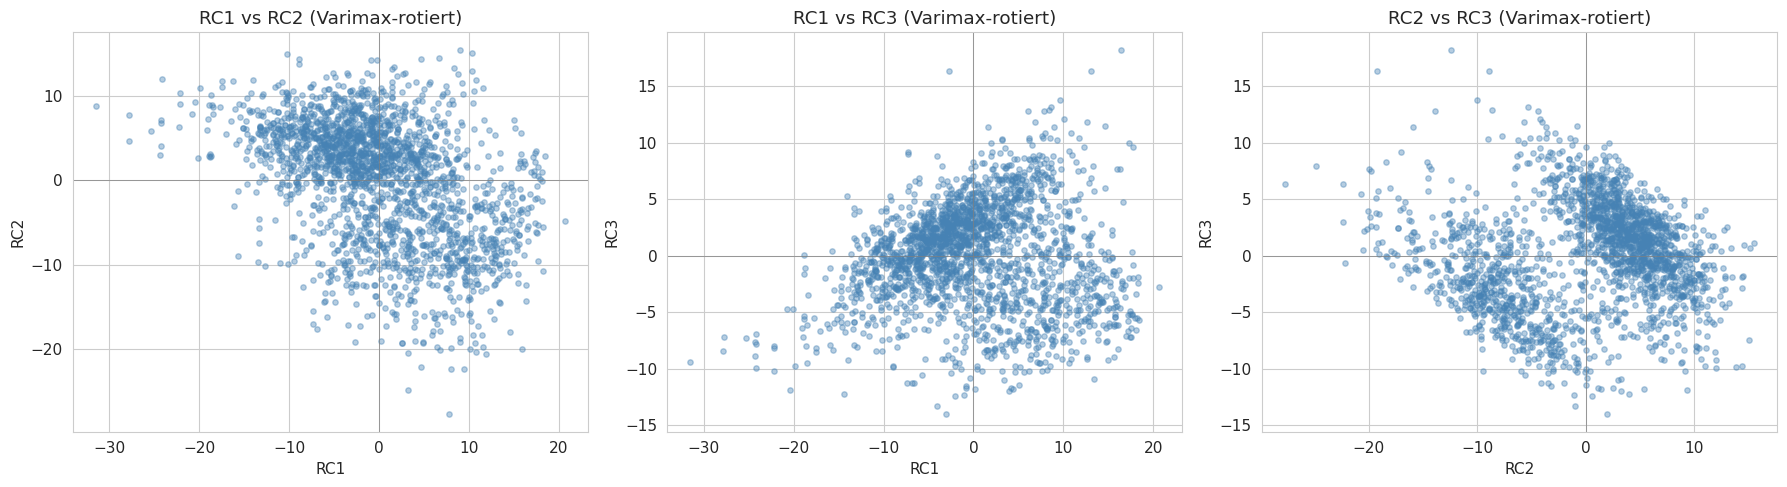

In [24]:
# Rotierte Scores berechnen
scores_rotated = scores_3 @ rotation_matrix

df_scores_rot = pd.DataFrame(
    scores_rotated,
    columns=['RC1', 'RC2', 'RC3'],
    index=df_imputed.index
).reset_index()

# Paarweise Plots der rotierten Faktoren
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# RC1 vs RC2
axes[0].scatter(df_scores_rot['RC1'], df_scores_rot['RC2'], alpha=0.4, s=15, c='steelblue')
axes[0].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[0].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
axes[0].set_xlabel('RC1')
axes[0].set_ylabel('RC2')
axes[0].set_title('RC1 vs RC2 (Varimax-rotiert)')

# RC1 vs RC3
axes[1].scatter(df_scores_rot['RC1'], df_scores_rot['RC3'], alpha=0.4, s=15, c='steelblue')
axes[1].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[1].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
axes[1].set_xlabel('RC1')
axes[1].set_ylabel('RC3')
axes[1].set_title('RC1 vs RC3 (Varimax-rotiert)')

# RC2 vs RC3
axes[2].scatter(df_scores_rot['RC2'], df_scores_rot['RC3'], alpha=0.4, s=15, c='steelblue')
axes[2].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[2].axvline(x=0, color='gray', linestyle='-', linewidth=0.5)
axes[2].set_xlabel('RC2')
axes[2].set_ylabel('RC3')
axes[2].set_title('RC2 vs RC3 (Varimax-rotiert)')

plt.tight_layout()
plt.savefig('pca_3_varimax_rotated.png', dpi=150, bbox_inches='tight')
plt.show()

## 9. Export der Ergebnisse

In [25]:
# Scores exportieren für weitere Analysen
df_scores_3.to_csv('municipality_pca_scores_3factors.csv', index=False)
df_scores_rot.to_csv('municipality_pca_scores_3factors_rotated.csv', index=False)

# Loadings exportieren
loadings_3.to_csv('proposal_loadings_3factors.csv')
loadings_rot_df.to_csv('proposal_loadings_3factors_rotated.csv')

print("Ergebnisse exportiert:")
print("  - municipality_pca_scores_3factors.csv")
print("  - municipality_pca_scores_3factors_rotated.csv")
print("  - proposal_loadings_3factors.csv")
print("  - proposal_loadings_3factors_rotated.csv")

Ergebnisse exportiert:
  - municipality_pca_scores_3factors.csv
  - municipality_pca_scores_3factors_rotated.csv
  - proposal_loadings_3factors.csv
  - proposal_loadings_3factors_rotated.csv


## 10. Zusammenfassung

In [26]:
print("="*80)
print("ZUSAMMENFASSUNG DER PCA-ANALYSE")
print("="*80)

print(f"\nDatenbasis:")
print(f"  - {df_imputed.shape[0]} Gemeinden")
print(f"  - {df_imputed.shape[1]} Abstimmungsvorlagen")
print(f"  - Zeitraum: 2000-2025")

print(f"\nFaktorenanalyse:")
print(f"  - Kaiser-Kriterium empfiehlt: {n_kaiser} Faktoren")
print(f"  - Literatur empfiehlt: 2-3 Faktoren")

print(f"\nErklärte Varianz (3 Faktoren):")
print(f"  - PC1: {pca_3.explained_variance_ratio_[0]*100:.1f}%")
print(f"  - PC2: {pca_3.explained_variance_ratio_[1]*100:.1f}%")
print(f"  - PC3: {pca_3.explained_variance_ratio_[2]*100:.1f}%")
print(f"  - Total: {pca_3.explained_variance_ratio_.sum()*100:.1f}%")

print(f"\nInterpretation der Dimensionen:")
print(f"  - PC1: Liberal ↔ Konservativ (gesellschaftlich)")
print(f"         Vorlagen: Einbürgerung, EU, Ausländerpolitik")
print(f"         Liberal: Zürich, Genf, Lausanne | Konservativ: Muotathal, Unteriberg")
print(f"")
print(f"  - PC2: Establishment ↔ Populistisch")
print(f"         Vorlagen: AHV-Reformen, Regierungsvorlagen vs. populistische Initiativen")
print(f"         Establishment: Zumikon, Küsnacht | Populistisch: Innerschweiz, Berner Jura")
print(f"         HINWEIS: Nicht identisch mit Links-Rechts!")
print(f"")
print(f"  - PC3: Ökologisch ↔ Technokratisch")
print(f"         Vorlagen: Umwelt, Energie, Pestizide")
print(f"         Ökologisch: Bern, Basel, Zürich | Technokratisch: ländliche Gemeinden")

print(f"\nBefund:")
print(f"  Die Analyse findet 2 starke + 1 schwächere Dimension.")
print(f"  Die wirtschaftliche Links-Rechts-Dimension ist in PC2 mit")
print(f"  Establishment/Populismus-Aspekten vermischt.")

ZUSAMMENFASSUNG DER PCA-ANALYSE

Datenbasis:
  - 2109 Gemeinden
  - 223 Abstimmungsvorlagen
  - Zeitraum: 2000-2025

Faktorenanalyse:
  - Kaiser-Kriterium empfiehlt: 18 Faktoren
  - Literatur empfiehlt: 2-3 Faktoren

Erklärte Varianz (3 Faktoren):
  - PC1: 35.9%
  - PC2: 14.1%
  - PC3: 9.0%
  - Total: 59.0%

Interpretation der Dimensionen:
  - PC1: Liberal ↔ Konservativ (gesellschaftlich)
         Vorlagen: Einbürgerung, EU, Ausländerpolitik
         Liberal: Zürich, Genf, Lausanne | Konservativ: Muotathal, Unteriberg

  - PC2: Establishment ↔ Populistisch
         Vorlagen: AHV-Reformen, Regierungsvorlagen vs. populistische Initiativen
         Establishment: Zumikon, Küsnacht | Populistisch: Innerschweiz, Berner Jura
         HINWEIS: Nicht identisch mit Links-Rechts!

  - PC3: Ökologisch ↔ Technokratisch
         Vorlagen: Umwelt, Energie, Pestizide
         Ökologisch: Bern, Basel, Zürich | Technokratisch: ländliche Gemeinden

Befund:
  Die Analyse findet 2 starke + 1 schwächere Di

In [27]:
# Datenbankverbindung schliessen
conn.close()
print("Datenbankverbindung geschlossen.")

Datenbankverbindung geschlossen.
